In [1]:
## Boiler plate code common to many notebooks.  See the TestFilesCommonCode.ipynb for details
from __future__ import print_function
%run TestFilesCommonCode.ipynb

SimpleITK Version: 0.9.1
Compiled: Sep 28 2015 10:07:41



In [2]:
InputDir='/scratch/TESTS/Aim2/Inputs'
OutputDir='/scratch/TESTS/Aim2/dwiDirectEdgeMap'

dwi_fn = os.path.join(InputDir,'DWI_Corrected_Aligned_CS.nrrd')
label_fn = os.path.join(InputDir,'fswm_extended_neuro2012_20_merge_seg.nii.gz')

In [3]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
#     Prepend the shell environment search paths
PROGRAM_PATHS = '/scratch/NAMICExternalProjects/release_20150715/bin'
PROGRAM_PATHS = PROGRAM_PATHS.split(':')
PROGRAM_PATHS.extend(os.environ['PATH'].split(':'))
os.environ['PATH'] = ':'.join(PROGRAM_PATHS)

CUSTOM_ENVIRONMENT=dict()

# Platform specific information
#     Prepend the python search paths
PYTHON_AUX_PATHS = '/scratch/BS/BRAINSTools/AutoWorkup'
PYTHON_AUX_PATHS = PYTHON_AUX_PATHS.split(':')
PYTHON_AUX_PATHS.extend(sys.path)
sys.path = PYTHON_AUX_PATHS

import SimpleITK as sitk
import nipype
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
from nipype.interfaces.freesurfer import ReconAll
from SEMTools import *

In [4]:
# Now we read dwi image and extract its b0
myExtracter = extractNrrdVectorIndex()
myExtracter.inputs.inputVolume = dwi_fn
myExtracter.inputs.vectorIndex = 1
myExtracter.inputs.outputVolume = os.path.join(OutputDir,'dwi_g1.nrrd')
print(myExtracter.cmdline)
myExtracter.run()

INFO:interface:stdout 2015-12-23T18:16:41.182907:Input Image: /scratch/TESTS/Aim2/Inputs/DWI_Corrected_Aligned_CS.nrrd
INFO:interface:stdout 2015-12-23T18:16:41.182907:Output Image: /scratch/TESTS/Aim2/dwiDirectEdgeMap/dwi_g1.nrrd
INFO:interface:stdout 2015-12-23T18:16:41.182907:Vector Index: 1
INFO:interface:stdout 2015-12-23T18:16:41.182907:Set Image Orientation: AsAcquired
INFO:interface:stdout 2015-12-23T18:16:41.182907:


 extractNrrdVectorIndex  --inputVolume /scratch/TESTS/Aim2/Inputs/DWI_Corrected_Aligned_CS.nrrd --outputVolume /scratch/TESTS/Aim2/dwiDirectEdgeMap/dwi_g1.nrrd --vectorIndex 1


In [5]:
'''
from nipype.interfaces.ants import DenoiseImage

denoise = DenoiseImage()
denoise.inputs.dimension = 3
denoise.inputs.input_image = myExtracter.inputs.outputVolume
denoise.inputs.output_image = [os.path.join(OutputDir,'dwi_g1_denoised.nii.gz')]
denoise.inputs.noise_model = 'Rician'
denoise.inputs.shrink_factor = 2
print(denoise.cmdline)
denoise.run()
'''

"\nfrom nipype.interfaces.ants import DenoiseImage\n\ndenoise = DenoiseImage()\ndenoise.inputs.dimension = 3\ndenoise.inputs.input_image = myExtracter.inputs.outputVolume\ndenoise.inputs.output_image = [os.path.join(OutputDir,'dwi_g1_denoised.nii.gz')]\ndenoise.inputs.noise_model = 'Rician'\ndenoise.inputs.shrink_factor = 2\nprint(denoise.cmdline)\ndenoise.run()\n"

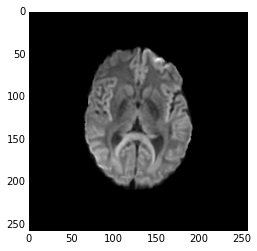

In [7]:
#dwi_g1 = sitk.ReadImage(os.path.join(OutputDir,'dwi_g1_denoised.nii.gz'))

dwi_g1 = sitk.ReadImage(os.path.join(OutputDir,'dwi_g1.nrrd'))
myshow(dwi_g1)

In [8]:
def ExtractBRAINFromHead(headImage, labelsMap):
    label_mask = labelsMap>0
    brainImage = sitk.Cast(headImage,sitk.sitkInt16) * sitk.Cast(label_mask,sitk.sitkInt16)
    return brainImage

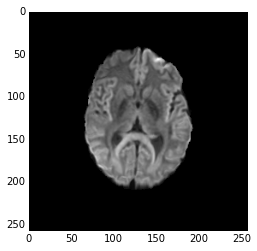

In [9]:
labelMap = sitk.ReadImage(label_fn)

# Now resample the brain mask to normalized space to remove DWI skull
resampler2 = sitk.ResampleImageFilter()
resampler2.SetReferenceImage(dwi_g1)
resampler2.SetInterpolator(sitk.sitkNearestNeighbor)
labelMap = resampler2.Execute(labelMap)

dwi_g1 = ExtractBRAINFromHead(dwi_g1,labelMap)
myshow(dwi_g1)

In [10]:
# Now set direction cosign of all images to identity
def ForceDCtoID(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    return inputVolume

def ForceOriginToZero(inputVolume):
    import os
    import SimpleITK as sitk
    inputVolume.SetOrigin((0.0, 0.0, 0.0))
    return inputVolume

In [11]:
dwi_g1 = ForceDCtoID(dwi_g1)
dwi_g1 = ForceOriginToZero(dwi_g1)

print(dwi_g1.GetSize())
print(dwi_g1.GetDirection())
print(dwi_g1.GetOrigin())

(256, 256, 61)
(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
(0.0, 0.0, 0.0)


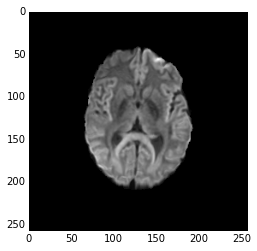

In [12]:
dwig1_s = dwi_g1[:,:,dwi_g1.GetSize()[2]/2]
myshow(dwig1_s)

In [13]:
stats = sitk.StatisticsImageFilter()
stats.Execute(dwig1_s)
inputImageMax = stats.GetMaximum()
inputImageMin = stats.GetMinimum()
inputImageMean = stats.GetMean()

print(inputImageMax)
print(inputImageMin)
print(inputImageMean)

1493.0
0.0
157.404846191


In [14]:
def NormalizeBetweenZeroAndOne(image):
    image_double = sitk.Cast(image, sitk.sitkFloat32)
    # new range
    newMax=1.0
    newMin=0
    # Find old range
    totalStats = sitk.StatisticsImageFilter()
    totalStats.Execute(image_double)
    oldMax=totalStats.GetMaximum()
    oldMin=totalStats.GetMinimum()
    f=(newMax-newMin)/(oldMax-oldMin)
    Normalized_image = (image_double-oldMin)*f+newMin
    return Normalized_image

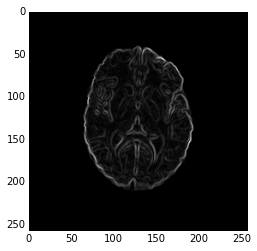

In [15]:
gradMagImage = sitk.GradientMagnitude(dwig1_s)
myshow(gradMagImage)

In [16]:
stats = sitk.StatisticsImageFilter()
stats.Execute(gradMagImage)
gradMagImageMax = stats.GetMaximum()
gradMagImageMin = stats.GetMinimum()
gradMagImageMean = stats.GetMean()

print(gradMagImageMax)
print(gradMagImageMin)
print(gradMagImageMean)

750.283447266
0.0
19.2447350049


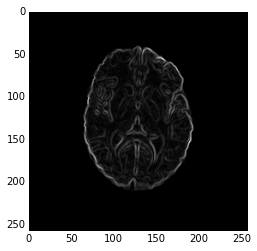

In [17]:
# Now normalize both t1g and t2g to have values between 0 and 1
edgeMask = NormalizeBetweenZeroAndOne(gradMagImage)
myshow(edgeMask)

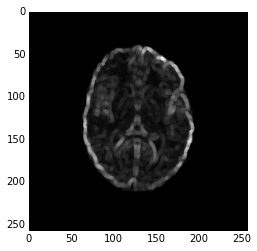

In [18]:
# use mask dilation
dil = sitk.GrayscaleDilateImageFilter()
dilatedEdgeMask = dil.Execute(edgeMask)
myshow(dilatedEdgeMask)
#edgeMask = dilatedEdgeMask

In [19]:
# invert the edge mask
inverter = sitk.InvertIntensityImageFilter()
edgeMask = inverter.Execute(edgeMask,1)

In [20]:
totalStats = sitk.StatisticsImageFilter()
totalStats.Execute(edgeMask)
print(totalStats.GetMaximum())
print(totalStats.GetMinimum())

1.0
0.0


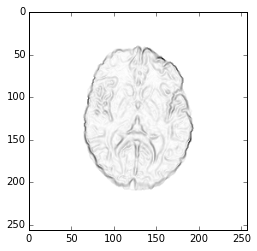

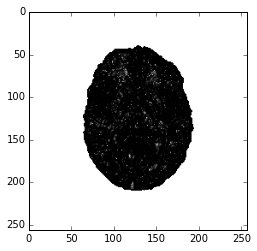

In [21]:
myshow(edgeMask)

sqredgeMask = sitk.Square(edgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)
sqredgeMask = sitk.Square(sqredgeMask)

myshow(sqredgeMask)

In [22]:
edge_arr = sitk.GetArrayFromImage(sqredgeMask)
#edge_arr = sitk.GetArrayFromImage(edgeMask)

import scipy.io
scipy.io.savemat(os.path.join(OutputDir,'edgemask_dwig1_python.mat'), mdict={'edgemask': edge_arr})

In [23]:
# Also, write the image to the disk
# Now normalize dwi_b0 to have values between 0 and 1
dwig1_s = NormalizeBetweenZeroAndOne(dwig1_s)
dwi_im_arr = sitk.GetArrayFromImage(dwig1_s)

import scipy.io
scipy.io.savemat(os.path.join(OutputDir,'dwig1_testdata.mat'), mdict={'inputImage': dwi_im_arr})